In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# Load the Titanic dataset from Kaggle
!pip install kaggle
from google.colab import files
files.upload()  # upload kaggle.json file

# Download the Titanic dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle competitions download -c titanic

# Unzip the dataset
!unzip titanic.zip

# Load the data into pandas DataFrame
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


Saving kaggle.json to kaggle.json
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 51.0MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Titanic dataset from Seaborn
df = sns.load_dataset('titanic')

# Display the first few rows
print(df.head())

# Summary statistics
print(df.describe())


   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.3815

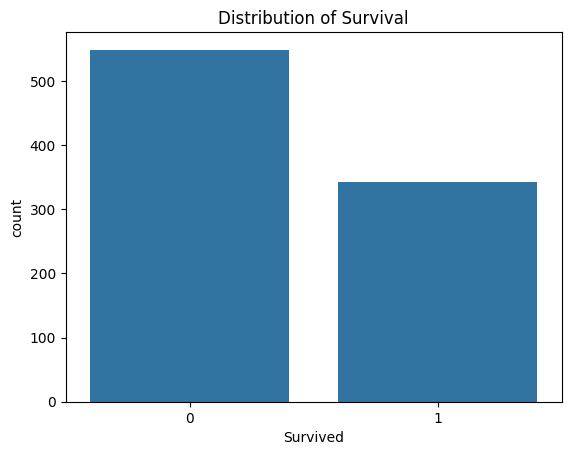

In [3]:
# Check the first few rows of the dataset
train_df.head()

# Check for missing values
train_df.isnull().sum()

# Visualize the distribution of survival
sns.countplot(x='Survived', data=train_df)
plt.title('Distribution of Survival')
plt.show()


Data Cleaning and Preprocessing

In [4]:
# Fill missing values for 'Age' with the median age
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

# Fill missing 'Embarked' with the most common port
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Drop the 'Cabin' column as it has too many missing values
train_df.drop('Cabin', axis=1, inplace=True)

# Convert categorical columns to numerical values
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'], drop_first=True)

# Drop columns that won't be useful in prediction
train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)


Feature Scaling

In [5]:
# Separate features and target variable
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Model Building and Evaluation

In [6]:
# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


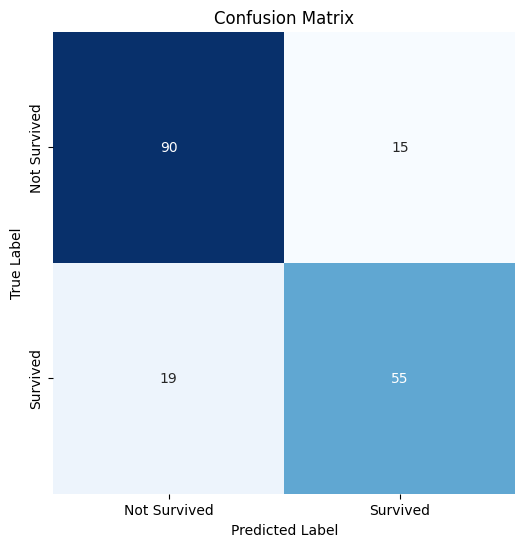

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [15]:
#accuracy of model
accuracy = model.score(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.8101


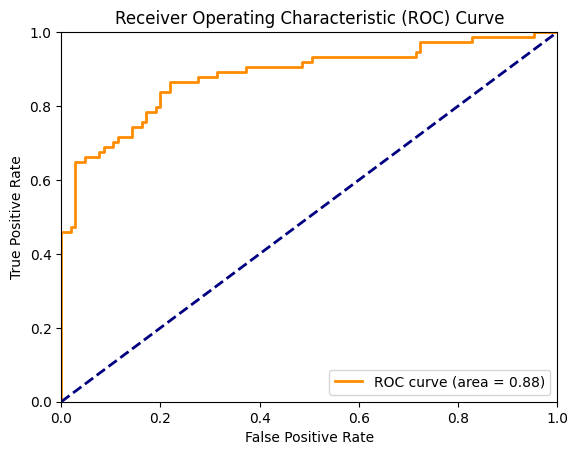

In [16]:
from sklearn.metrics import roc_curve, auc

# Get probability estimates for positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [9]:
# Load the test set again to get the 'PassengerId'
test_df = pd.read_csv("test.csv")

# Save the 'PassengerId' column for the submission file
passenger_ids = test_df['PassengerId']

# Preprocess the test set as done earlier
test_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'], drop_first=True)
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Scale the test features
test_df = scaler.transform(test_df)

# Make predictions on the test set
predictions = model.predict(test_df)

# Prepare the submission file with the preserved 'PassengerId'
submission = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
submission.to_csv('titanic_submission.csv', index=False)
